In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from artcv.model import ArtCV
from artcv.trainer import Trainer
from artcv.datatool import ImgDataset, TrainValSet
import sys
torch.cuda.is_available()

True

In [2]:
# indices = [i for i in range(0, 2096)]
indices = None
dataset = TrainValSet(indices=indices)

In [3]:
model = ArtCV()
file_name = '04302020_resnet18_1layer.model.pkl'
save_path = f'{sys.path[0]}/weights/{file_name}'
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [4]:
trainer = Trainer(model, dataset, batch_size_train=512, batch_size_val=512, batch_size_all=1024,
                  dataloader_train_kwargs={'num_workers':4}, dataloader_val_kwargs={'num_workers':4},
                 dataloader_all_kwargs={'num_workers':4})

In [ ]:
trainer.train()

Training progress:   1%|          | 1/100 [14:31<23:57:18, 871.10s/it]

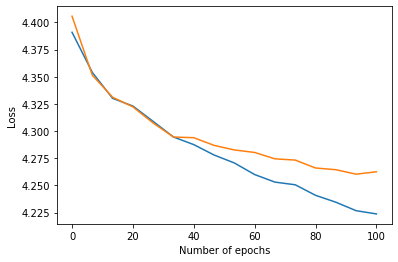

In [6]:
trainer.loss_history_plot()

In [5]:
predictions_array = trainer.get_probs(tag='all')

In [ ]:
file_name = '04302020_resnet18_1layer_probs.npy'
save_path = f'{sys.path[0]}/weights/{file_name}'
np.save(save_path, predictions_array)

In [11]:
import sys
file_name = '04302020_resnet18_1layer.model.pkl'
save_path = f'{sys.path[0]}/weights/{file_name}'
torch.save(trainer.model.state_dict(), save_path)

In [6]:
itertool = iter(trainer.dataloader_train)
img, y0, y1, y2, y3, y4 = itertool.next()

In [24]:
ground_truth = []
ground_truth += [torch.cat((y0.long().cpu(),
                                        y1.long().cpu(),
                                        F.one_hot(y2, num_classes=6).squeeze()[:, 1:].long().cpu(),
                                        y3.long().cpu(),
                                        y4.long().cpu()), dim=1)]
ground_truth += [torch.cat((y0.long().cpu(),
                                        y1.long().cpu(),
                                        F.one_hot(y2, num_classes=6).squeeze()[:, 1:].long().cpu(),
                                        y3.long().cpu(),
                                        y4.long().cpu()), dim=1)]

In [10]:
y_concat_prob = model.get_concat_probs(img.cuda())

In [13]:
predictions_tem = []
predictions_tem += [y_concat_prob.cpu()]
predictions_tem += [y_concat_prob.cpu()]

In [20]:
predictions_tem

[tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5051, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
        grad_fn=<CopyBackwards>),
 tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5051, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
        grad_fn=<CopyBackwards>)]

In [25]:
torch.cat(ground_truth).detach().numpy().shape

(64, 3474)

In [18]:
predictions_array = torch.cat(predictions_tem).detach().numpy()

In [21]:
predictions_array.shape

(64, 3474)

In [16]:
F.one_hot(y2, num_classes=6).squeeze()[:, 1:].long().cpu()


tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])

In [20]:
torch.nn.functional.one_hot(y2, num_classes=6).squeeze()[:, 1:]

tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]])

In [7]:
y_pred0, y_pred1, y_pred2, y_pred3, y_pred4 = model.get_probs(img.cuda())

In [15]:
y_pred0.shape

torch.Size([16, 100])

In [20]:
torch.mean(torch.nn.functional.binary_cross_entropy(y_pred1, y1, reduction='none'), dim=1)

RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'target' in call to _thnn_binary_cross_entropy_forward